TokaMaker Example: Bridging fixed- to free-boundary {#doc_tMaker_fixed_ex2}
==========
In this example we show how to compute a fixed-boundary equilibria using TokaMaker and then compute the necessary currents in a coil set to produce this equilbrium in free-boundary and confirm the validity of these currents using a free-boundary calculation. This demonstrates representative steps required to design coilsets for a new machine with desired plasma configurations.

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk, eval_green
from OpenFUSIONToolkit.util import mu0

## Create mesh
First we define a target size to set the resolution in our grid. This variable will be used later and represent the target edge size within our mesh, where units are in meters. In this case we are using a fairly coarse resolution of 1.5 cm (10 radial points). Note that when setting up a new machine these values will need to scale with the overall size of the device/domain. It is generally a good idea perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions, when working with a new geometry to ensure the results are not sensitive to your choice of grid size.

### Define boundary
For this example we will first generate a mesh for fixed-boundary calculation using the simple flux surface definition in \ref OpenFUSIONToolkit.TokaMaker.create_isoflux "create_isoflux". This function parameterizes a surface using a center point (R,Z), minor radius (a), and elongation and triangularity, which can can optionally have different upper and lower value. For this case we make a plasma comparable to those generated in the LTX-$\beta$ device at the Princeton Plasma Physics Laboratory.

In [3]:
mesh_dx = 0.015
LCFS_contour = create_isoflux(80,0.42,0.0,0.15,1.3,0.1)

### Define regions and attributes
We now create the mesh object and define the various logical mesh regions. In this case we only have one region, which is named `plasma` and is of type `plasma`. See other examples for more complex cases with other region types.

In [4]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('plasma',mesh_dx,'plasma')

### Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.

In [5]:
gs_mesh.add_polygon(LCFS_contour,'plasma')

### Generate mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh" method. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [6]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()

Assembling regions:
  # of unique points    = 72
  # of unique segments  = 1
Generating mesh:
  # of points  = 654
  # of cells   = 1234
  # of regions = 1


### Plot resulting regions and grid
We now plot the mesh to inspect proper generation.

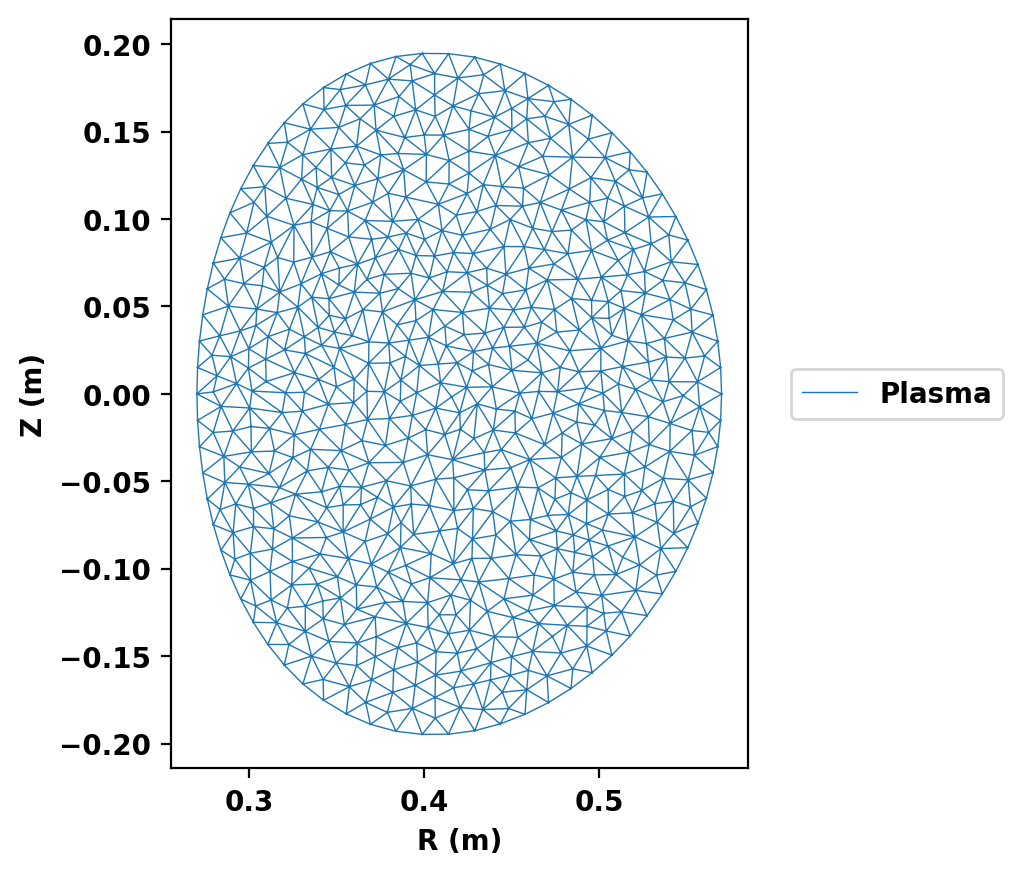

In [7]:
fig, ax = plt.subplots(1,1,figsize=(5,8),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [8]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_geo
Revision id:          6287669
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated above using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh" and set the code to operate in fixed boundary mode by setting the `free_boundary` setting to False. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [9]:
mygs.setup_mesh(mesh_pts,mesh_lc)
mygs.settings.free_boundary = False
mygs.setup(order=2,F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  9.160E-02
    # of points  =     654
    # of edges   =    1887
    # of cells   =    1234
    # of boundary points =      72
    # of boundary edges  =      72
    # of boundary cells  =      72
  Resolution statistics:
    hmin =  9.364E-03
    hrms =  1.372E-02
    hmax =  2.120E-02
  Surface grounded at vertex       1


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1



### Define global quantities and targets
For the Grad-Shafranov solve we define targets for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

In [10]:
Ip_target = 120.E3
Beta_target = 0.5
mygs.set_targets(Ip=Ip_target,Ip_ratio=(1.0/Beta_target - 1.0))

### Initialize the flux function
Before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". By default this calculation uses a uniform current (equal to Ip_target) over the full plasma domain. Additional options are also availble to tailor this distribution for more control.

In [11]:
err_flag = mygs.init_psi()

### Compute a fixed-boundary equilibrium
Now we can compute an equilibrium in this geometry using the default profiles for F*F' and P' by running \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve"

In [12]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  5.2510E-01  1.5221E+00  3.4195E-04  4.3753E-01 -1.8616E-05  0.0000E+00
     2  5.4710E-01  1.5807E+00  9.8473E-05  4.3783E-01 -1.2154E-05  0.0000E+00
     3  5.5322E-01  1.5967E+00  2.9204E-05  4.3795E-01 -9.9009E-06  0.0000E+00
     4  5.5504E-01  1.6014E+00  8.8720E-06  4.3801E-01 -8.9890E-06  0.0000E+00
     5  5.5560E-01  1.6028E+00  2.7479E-06  4.3803E-01 -8.6008E-06  0.0000E+00
     6  5.5577E-01  1.6033E+00  8.6452E-07  4.3804E-01 -8.4305E-06  0.0000E+00
 Timing:   1.3071999885141850E-002
   Source:     6.4640003256499767E-003
   Solve:      1.8750000745058060E-003
   Boundary:   8.2700001075863838E-004
   Other:      3.9059994742274284E-003


### Print information and plot equilibrium
After computing the equilibrium, basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

Flux surfaces can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. Additional plotting methods are also available to display other information for more complex cases. See other examples and the documentation for more information.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.1999E+05
  Current Centroid [m]    =    0.422 -0.000
  Magnetic Axis [m]       =    0.438 -0.000
  Elongation              =    1.297 (U:  1.297, L:  1.297)
  Triangularity           =    0.137 (U:  0.138, L:  0.136)
  Plasma Volume [m^3]     =    0.240
  q_0, q_95               =    0.513  0.875
  Peak Pressure [Pa]      =    1.0655E+04
  Stored Energy [J]       =    1.3677E+03
  <Beta_pol> [%]          =   49.0832
  <Beta_tor> [%]          =   14.6149
  <Beta_n>   [%]          =    4.6422
  Diamagnetic flux [Wb]   =    1.5540E-03
  Toroidal flux [Wb]      =    2.6027E-02
  l_i                     =    0.7419


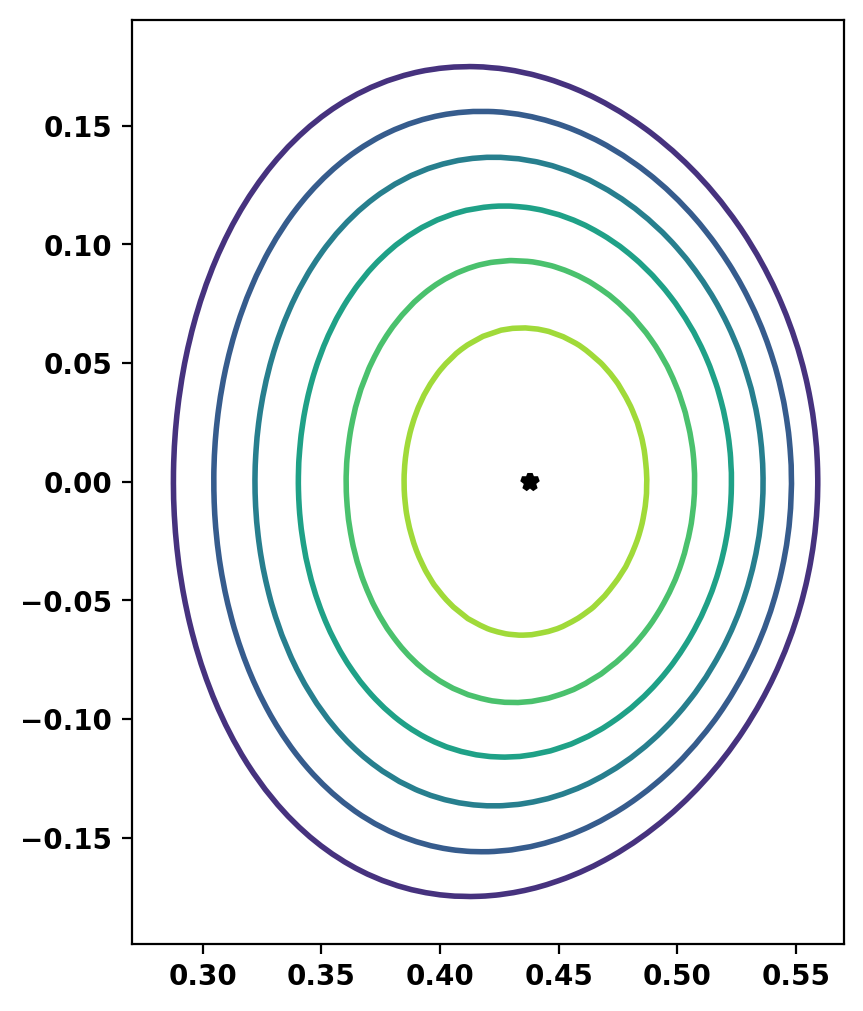

In [13]:
mygs.print_info()
# Plot flux surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_psi(fig,ax)

## Find required external coils
Now we will find the required coil currents in a set of coils to produce this equilibrium in free-boundary. While this approach finds the necessary currents in coils at fixed locations a similar process could also be used to optimize coil sets with multiple fixed-boundary equilibria as shapes.

### Get required coil flux on boundary
To do this we first get the flux on the boundary due to the plasma current alone. This will need to be matched external coils in order for the boundary of the fixed-boundary equilibrium to be a flux surface in the corresponding free-boundary equilibrium. For a fixed-boundary equilibrium this can be computed using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_vfixed "get_vfixed"

Computing fixed boundary vacuum flux
 Computing flux BC matrix 
 Inverting real matrix
   Time =    4.5100000000000001E-004
 Starting LU solver: umfpack T


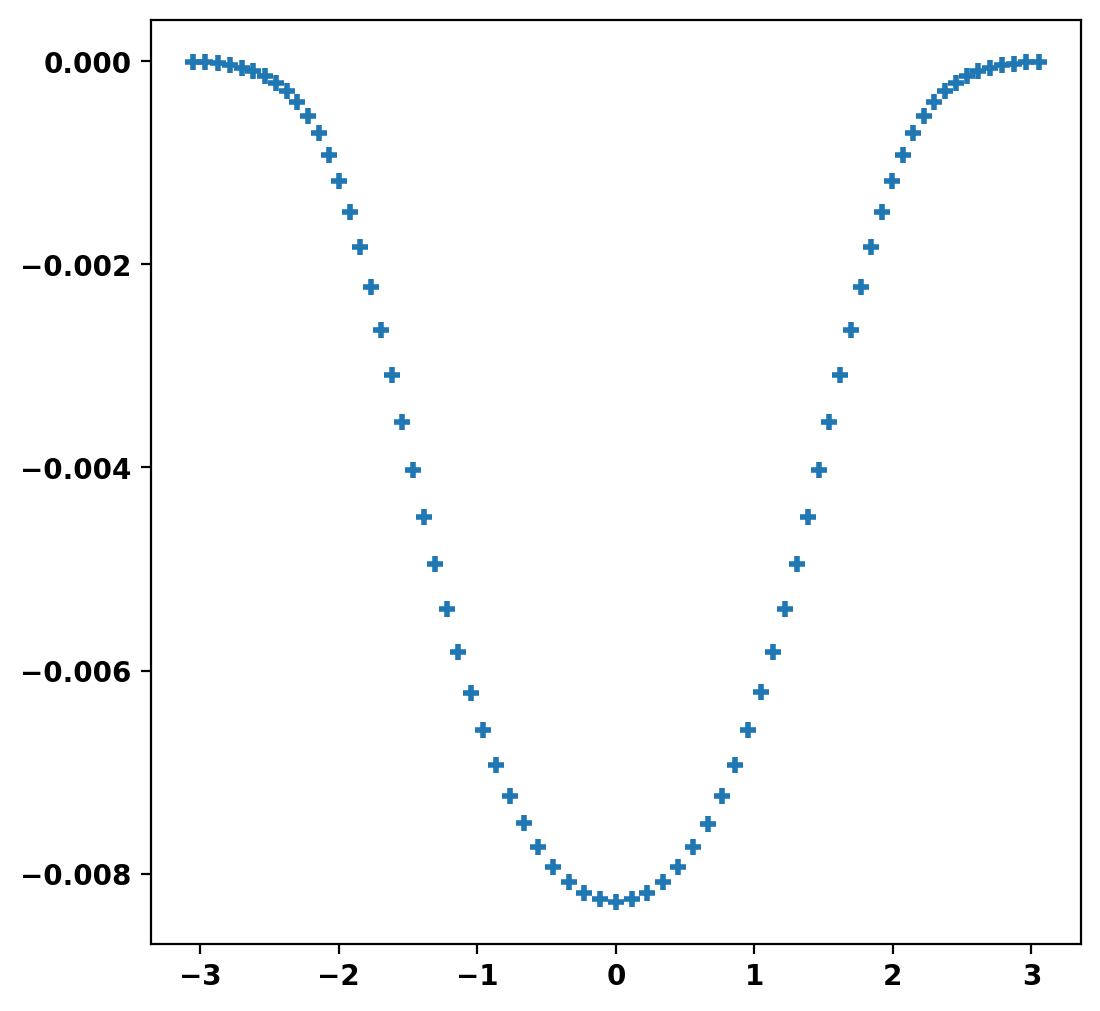

In [14]:
r_bnd, psi_bnd = mygs.get_vfixed()
# Plot required relative flux on boundary
fig, ax = plt.subplots()
theta = np.arctan2(r_bnd[:,1],r_bnd[:,0]-mygs.o_point[0])
_=ax.plot(theta[1:],psi_bnd[1:]-psi_bnd[0],'+')

### Find approximate coil currents to match
Next we find the required current in a fixed set of coils to match this flux. In this case we use coils that roughly approximate a subset of the coils in the LTX-$\beta$ device. Then we build a mapping from the coils to the flux generated on the plasma boundary using the toroidal Green's function \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.eval_green "eval_green". An additional regularization term is also included to improve behavior of the resulting currents. 

Coil currents [kA-turns]:
       21.3395
      -22.4770
       15.4025
      -53.2023
       76.8847
      -22.0964
      138.9423


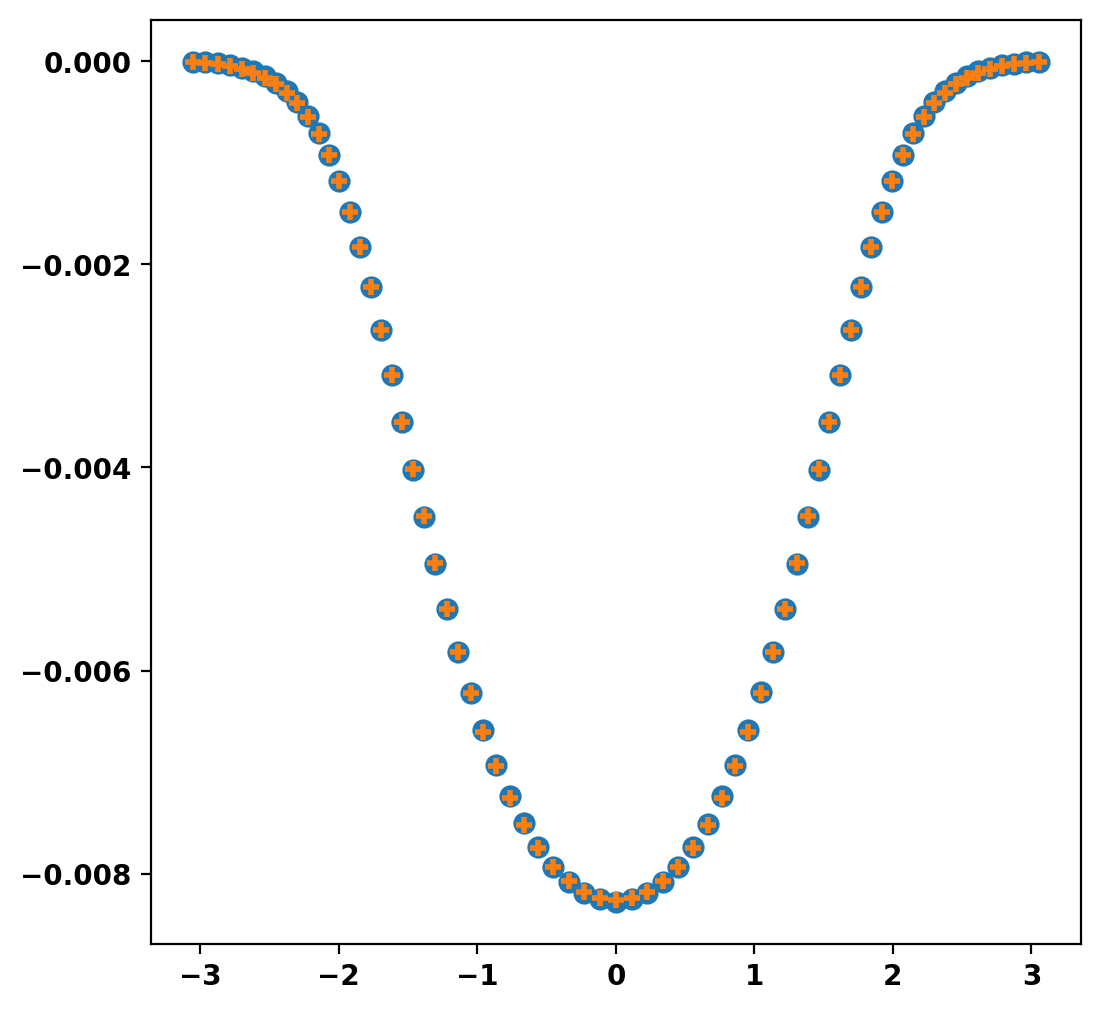

In [15]:
# Define coil positions
coils = [
    np.asarray([[0.67287,0.49371],[0.67287,-0.49371]]),
    np.asarray([[0.40958,0.80565],[0.40958,-0.80565]]),
    np.asarray([[0.71120,0.80170],[0.71120,-0.80170]]),
    np.asarray([[0.08900,0.49000],[0.08900,-0.49000]]),
    np.asarray([[0.86177,0.40640],[0.86177,-0.40640]]),
    np.asarray([[0.63106,0.36671],[0.63106,-0.36671]]),
    np.asarray([[0.07465,0.3],[0.07465,0.2],[0.07465,0.1],[0.07465,0.0],[0.07465,-0.1],[0.07465,-0.2],[0.07465,-0.3]])
]
# Build least-square system from mapping of coil filaments to flux on fixed boundary
con = np.zeros((psi_bnd.shape[0]+len(coils)-1,len(coils)))
for i, coil_set in enumerate(coils):
    flux_tmp = np.zeros((psi_bnd.shape[0],))
    for coil in coil_set:
        flux_tmp += eval_green(r_bnd,coil)
    con[:psi_bnd.shape[0]-1,i] = flux_tmp[1:] - flux_tmp[0]
    con[psi_bnd.shape[0]-1+i,i] = 1.E-9 # Regularization term
# Perform least-squares fit
err = np.zeros((psi_bnd.shape[0]+len(coils)-1,))
err[:psi_bnd.shape[0]-1] = psi_bnd[1:] - psi_bnd[0]
currs = np.linalg.lstsq(con, err, rcond=None)[0]
# Print currents and plot match
fig, ax = plt.subplots()
ax.plot(theta[1:],psi_bnd[1:]-psi_bnd[0],'o')
ax.plot(theta[1:],np.dot(con,currs)[:psi_bnd.shape[0]-1],'+')
print('Coil currents [kA-turns]:')
for val in currs:
    print('  {0:12.4f}'.format(val/1.E3))

## Compute free-boundary solution with new coils
To show demonstrate the result we now compute a free-boundary equilibrium with the coil currents computed in the previous step. This will use a simple rectangular domain for the plasma, which we will design to limit on the outboard surface at the same location as the fixed-boundary case above.

### Set mesh resolution for each region
First we define some target sizes to set the resolution in our free-boundary grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. Because we used filament coils above we will use small square coils (1 cm x 1 cm), so a high resolution is used in the coil regions.

In [16]:
plasma_dx = 0.01
coil_dx = 0.005
vac_dx = 0.06

### Define regions and attributes
We now create and define the various logical mesh regions. In this case we have three regions:
 - `air`: The region outside the limiter, which is treated like a vacuum
 - `plasma`: The region inside the limiter where the plasma will exist
 - `PF_I_J,...`: Each of the j coils in the i coil sets defined above

For each region we provide a target size and specify the region type:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `coil`: A region where toroidal current can flow with specified amplitude through \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents

In [17]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')
gs_mesh.define_region('plasma',plasma_dx,'plasma')
# Define each of the PF coils
for i, coil_set in enumerate(coils):
    for j, coil in enumerate(coil_set):
        gs_mesh.define_region('PF_{0}_{1}'.format(i,j),coil_dx,'coil')

### Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. We add the limiter contour as a "rectangle", referencing `plasma` as the region enclosed by the contour and `air` as the region outside the contour.
 2. We add each of the coils in the 7 coil sets as "rectangles", which are defined by a center point (R,Z) along with a width (W) and height (H). We also reference `air` as the region outside the coils.

In [18]:
maxes = LCFS_contour.max(axis=0)
mins = LCFS_contour.min(axis=0)
# Define geometry
gs_mesh.add_rectangle((maxes[0]+mins[0])/2.0-0.025,(maxes[1]+mins[1])/2.0,maxes[0]-mins[0]+0.05,(maxes[1]-mins[1])*1.2,'plasma',parent_name='air')
# Define the shape of the PF coils
for i, coil_set in enumerate(coils):
    for j, coil in enumerate(coil_set):
        gs_mesh.add_rectangle(coil[0],coil[1],0.01,0.01,'PF_{0}_{1}'.format(i,j),parent_name='air')

### Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place.

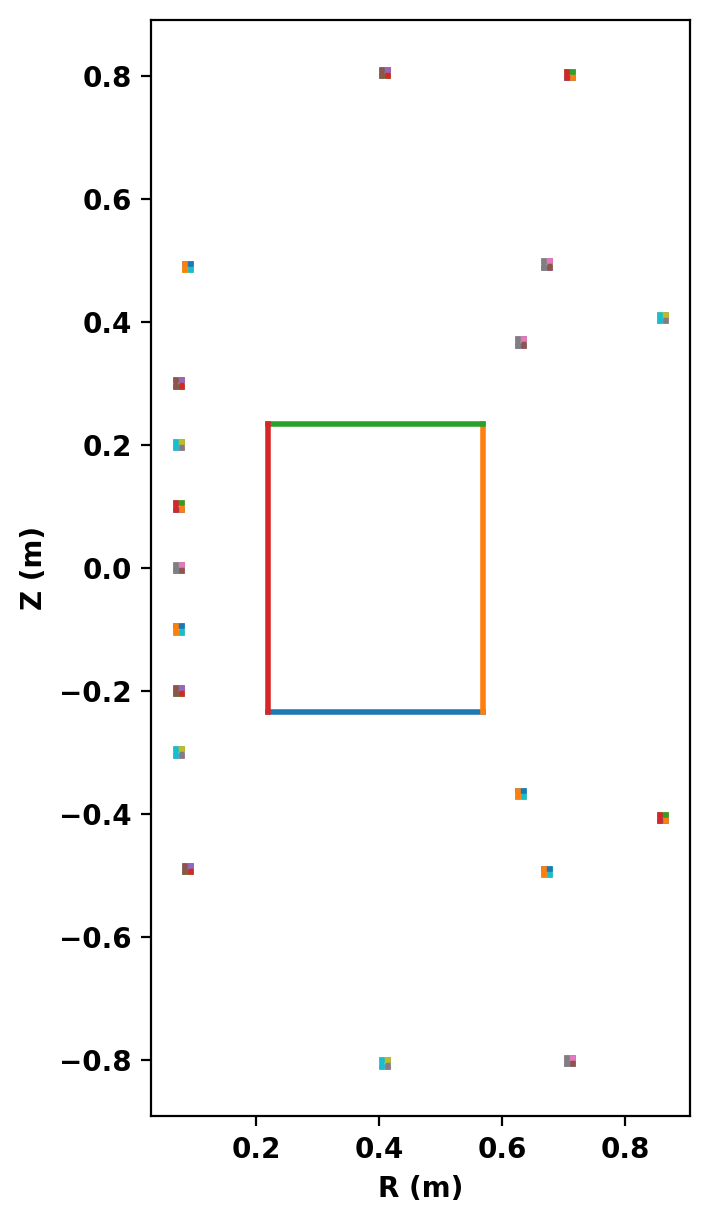

In [19]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

### Create mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh" method. Additionally, if `coil` and/or `conductor` regions are defined the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_coils "get_coils" and \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_conductors "get_conductors" methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [20]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 412
  # of unique segments  = 84
Generating mesh:
  # of points  = 3915
  # of cells   = 7730
  # of regions = 21


### Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

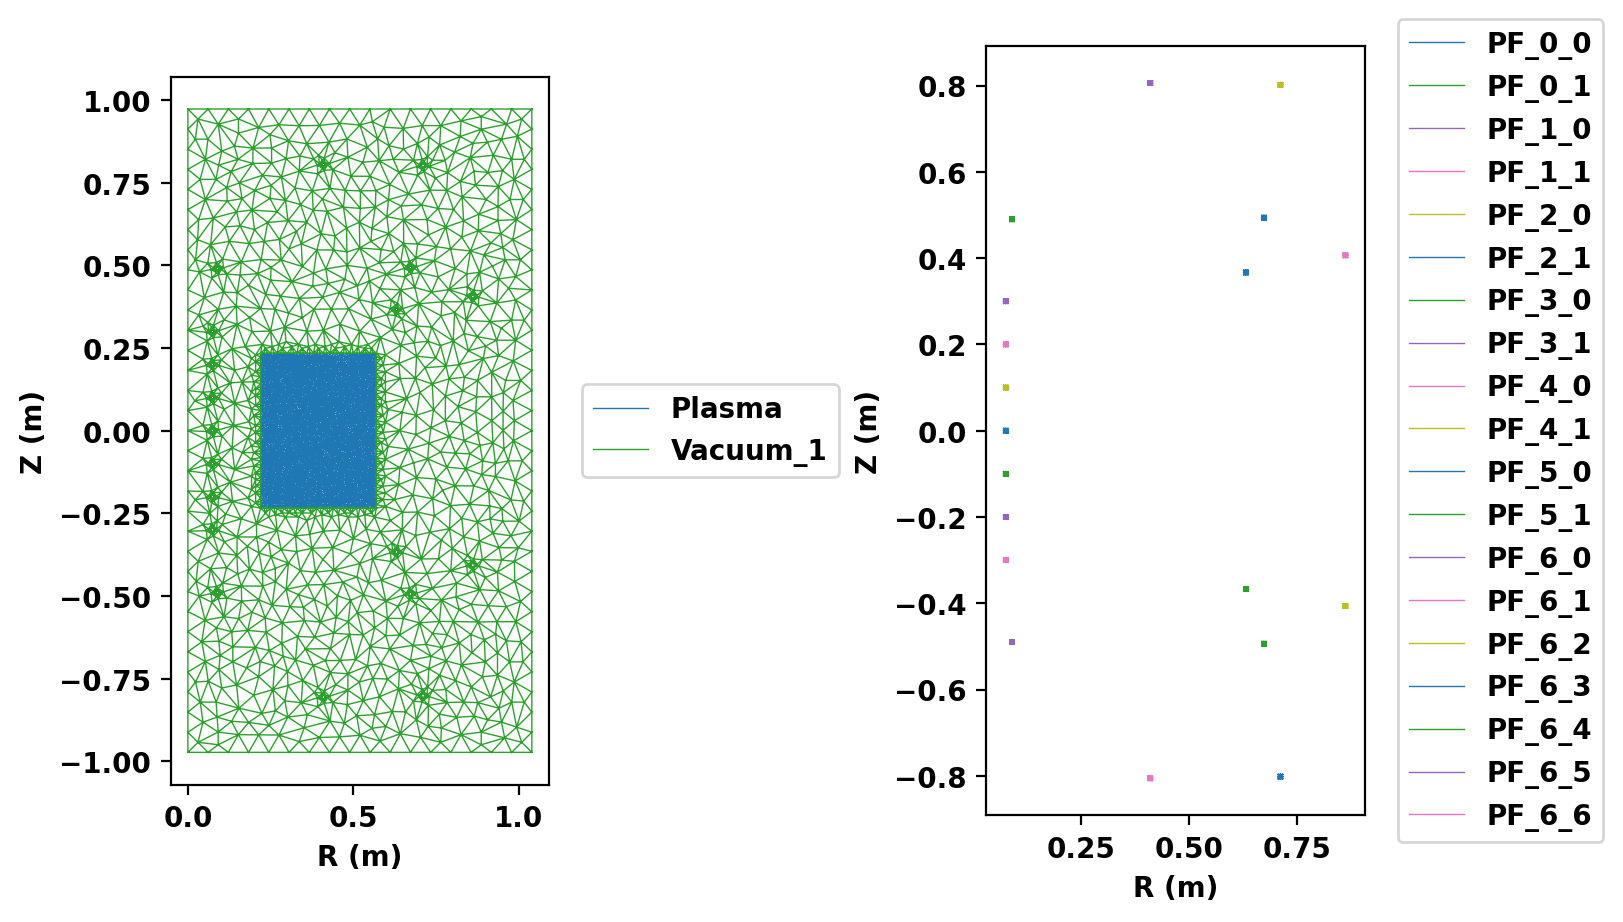

In [21]:
fig, ax = plt.subplots(1,2,figsize=(8,6),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

### Update mesh in TokaMaker
As in \ref doc_tMaker_fixed_ex1 we clear the prior representation and prepare TokaMaker to accept a new configuration. Then we load in the new mesh as above, but we now use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions" to define the different region types. Additionally, we set this run as free-boundary.

In [22]:
mygs.reset()
mygs.setup_mesh(mesh_pts,mesh_lc,mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.settings.free_boundary = True
mygs.setup(order=2,F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.024E+00
    # of points  =    3915
    # of edges   =   11644
    # of cells   =    7730
    # of boundary points =      98
    # of boundary edges  =      98
    # of boundary cells  =      98
  Resolution statistics:
    hmin =  3.536E-03
    hrms =  2.630E-02
    hmax =  8.794E-02
  Surface grounded at vertex     348


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    6.2299999999999996E-004


### Define a vertical stability coil
The equilibrium we are trying to compute is slightly vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the first coil set.

In [23]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[mygs.coil_sets['PF_5_0']['id'],mygs.coil_sets['PF_5_1']['id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Set coil currents
We now set the current in each coil to the currents computed by the least-square fit above. This is done using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents "set_coil_currents" method, where currents are given in the total number of Amps flowing in the coil (also known as Amp-turns). The current is the same in each coil of a given coil set. Additionally, the current needs to be in the opposite direction as above.

In [24]:
new_coil_currents = np.zeros((mygs.ncoils,))
for i, coil_set in enumerate(coils):
    for j, coil in enumerate(coil_set):
        new_coil_currents[mygs.coil_sets['PF_{0}_{1}'.format(i,j)]['id']] = -currs[i]
mygs.set_coil_currents(new_coil_currents)

### Define global quantities and targets
Again we define a target for the plasma current, but instead of a target Ip_ratio we target the radial and vertical position of on the magnetic axis from the fixed boundary calculation above. The radial position is used to control the plasma pressure and the vertical position is used along with the VSC above to keep the plasma centered.

In [25]:
Ip_target = 120.E3
R0_target = 0.438
Z0 = 0.0
mygs.set_targets(Ip=Ip_target,R0=R0_target,V0=Z0)

### Compute a free-boundary equilibrium
Now we can compute a free-boundary equilibrium for comparison with the fixed-boundary case above. Note that as we updated the mesh we must call the flux function initialization method before this solve.

In [26]:
err_flag = mygs.init_psi(0.42,0.0,0.15,1.0,0.0)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  3.9624E-01  1.3452E+00  2.9105E-04  4.1373E-01 -4.7320E-05  2.2853E+01
     2  3.0204E-01  1.7603E+00  1.2320E-04  4.1704E-01 -4.1139E-05  1.2697E+01
     3  2.5206E-01  1.9158E+00  1.2723E-04  4.2089E-01 -2.9541E-05  5.4535E+00
     4  2.1893E-01  1.9977E+00  1.3781E-04  4.2486E-01 -2.3839E-05  4.5089E+01
     5  1.9260E-01  2.0534E+00  1.4273E-04  4.2889E-01 -1.6533E-05  4.8542E+01
     6  1.7165E-01  2.0924E+00  1.4522E-04  4.3293E-01 -1.9318E-05 -9.1034E-01
     7  1.5035E-01  2.1309E+00  1.9401E-04  4.3698E-01  1.9367E-06  2.8072E+01
     8  2.7379E-01  1.9027E+00  1.6599E-04  4.3780E-01  3.5100E-07  1.4308E+01
     9  3.4573E-01  1.8106E+00  1.3395E-04  4.3796E-01  6.0969E-08  1.3342E+01
    10  3.9456E-01  1.7608E+00  1.0464E-04  4.3799E-01  1.0711E-08  1.2991E+01
    11  4.2984E-01  1.7293E+00  8.0072E-05  4.3800E-01  1.9408E-09  1.6145E+01
    12  4.5575E-01  1.7079E+00  6.0359E-05  4.3800E-01  3.6674E-10  1.6215E+01
    13  4.7481E-01  1.

### Compare free- and fixed-boundary cases
Plotting the LCFS of the fixed-boundary equilibrium over the free-boundary result shows good agreement, but minor differences as a finite coil set cannot, in general, exactly reproduce any arbitrary plasma shape.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.1998E+05
  Current Centroid [m]    =    0.421  0.000
  Magnetic Axis [m]       =    0.438  0.000
  Elongation              =    1.303 (U:  1.303, L:  1.303)
  Triangularity           =    0.100 (U:  0.100, L:  0.100)
  Plasma Volume [m^3]     =    0.242
  q_0, q_95               =    0.514  0.890
  Peak Pressure [Pa]      =    1.0994E+04
  Stored Energy [J]       =    1.4234E+03
  <Beta_pol> [%]          =   51.1428
  <Beta_tor> [%]          =   15.0196
  <Beta_n>   [%]          =    4.7969
  Diamagnetic flux [Wb]   =    1.4881E-03
  Toroidal flux [Wb]      =    2.6300E-02
  l_i                     =    0.7421


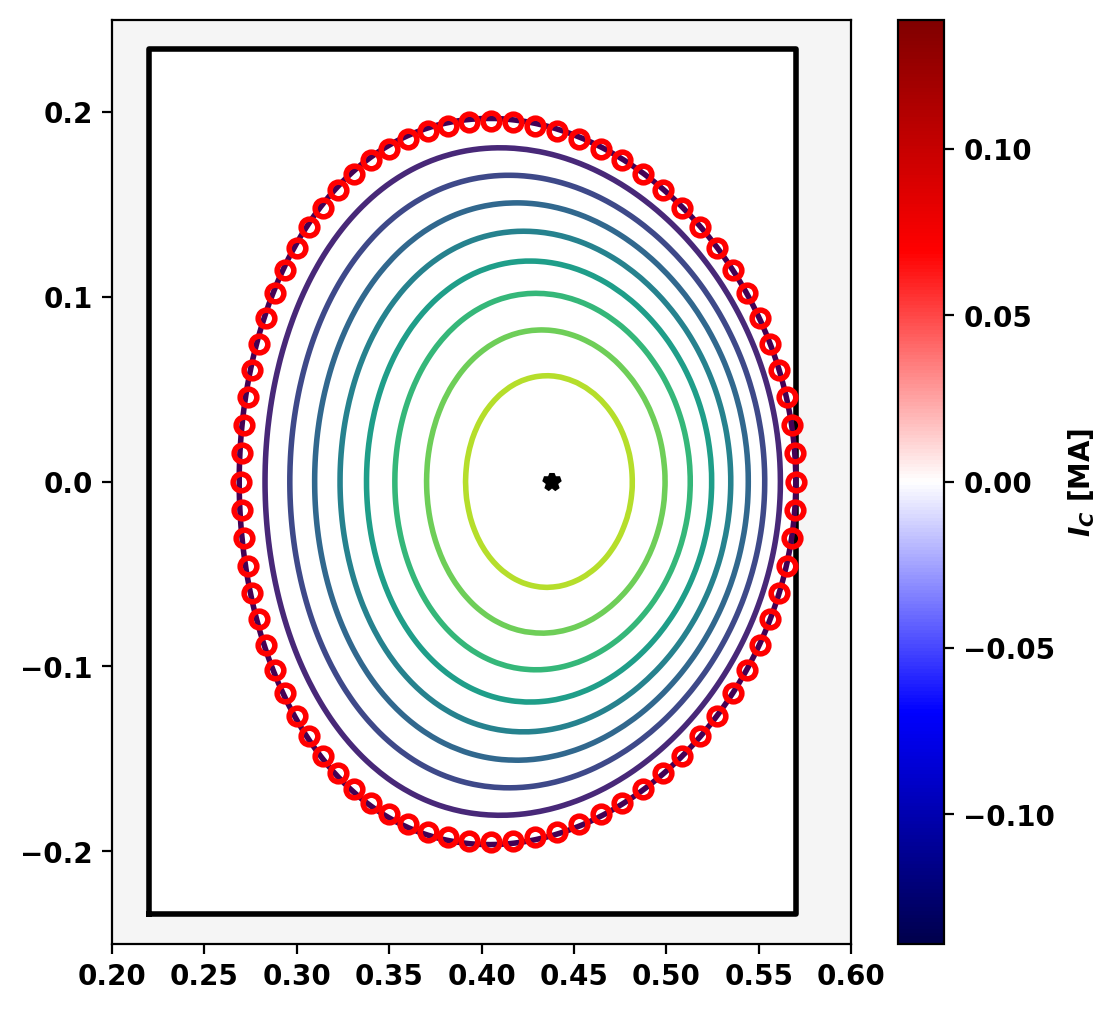

In [27]:
mygs.print_info()
# Plot flux surfaces and source LCFS
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,plasma_nlevels=10,vacuum_nlevels=4)
ax.plot(LCFS_contour[:,0],LCFS_contour[:,1],'ro',fillstyle='none')
ax.set_ylim(-0.25,0.25)
_ = ax.set_xlim(0.2,0.6)